# Recurrent Neural Networks in Pytorch

<img src='https://www.cs.colostate.edu/~anderson/cs545/notebooks/recurrent.png' width='600'>

In [58]:
import numpy as np
import torch
import gzip
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output

In [59]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.rnn = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, hidden = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])
        return out

In [60]:
def load_mnist():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    Xtrain = train_set[0]
    Ttrain = train_set[1].reshape(-1, 1)
    Xval = valid_set[0]
    Tval = valid_set[1].reshape(-1, 1)
    Xtest = test_set[0]
    Ttest = test_set[1].reshape(-1, 1)
    Xtrain = np.vstack((Xtrain, Xval))
    Ttrain = np.vstack((Ttrain, Tval))
    return Xtrain, Ttrain, Xtest, Ttest

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [62]:
Xtrain, Ttrain, Xtest, Ttest = load_mnist()
Xtrain = Xtrain.reshape(-1, 28, 28)
Xtest = Xtest.reshape(-1, 28, 28)

Xtrain = torch.from_numpy(Xtrain.astype(np.float32)).to(device)
Ttrain = torch.from_numpy(Ttrain.astype(np.int64)).to(device)

In [63]:
def get_batch(X, T, batch_size=100):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows]
    T = T[rows]
    for first in range(0, n_samples, batch_size):
        last = first + batch_size
        yield X[first:last], T[first:last]
    # should return last batch of n_samples not evenly divided by batch_size

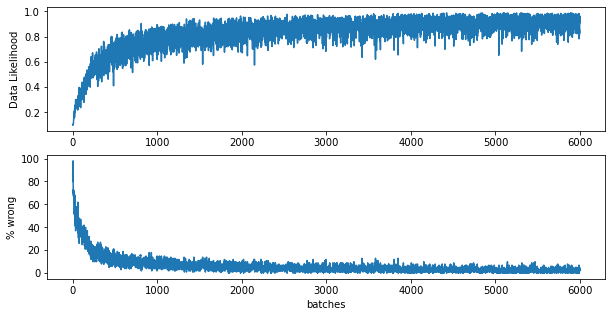

In [66]:
graphics = True

if graphics:
    fig = plt.figure(figsize=(10, 5))

sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 10
learning_rate = 0.001

model = RNN(input_size, hidden_size, num_layers, num_classes)
model = model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  

error_trace = []
percent_wrong = []

for epoch in range(num_epochs):
    for i, (X, T) in enumerate(get_batch(Xtrain, Ttrain, batch_size)):

        X = X.to(device)
        T = T.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_func(outputs, T.reshape(-1))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        error_trace.append(np.exp(-loss.detach().cpu()))
        Yc = outputs.cpu().detach().numpy().argmax(1).reshape(-1, 1)
        Tc = T.cpu().numpy()
        percent = (sum(Yc != Tc)/len(Tc))[0]*100
        percent_wrong.append(percent)
        
        if graphics:
            fig.clf()
            plt.subplot(2, 1, 1)
            plt.plot(error_trace)
            plt.ylabel('Data Likelihood')
            plt.subplot(2, 1, 2)
            plt.plot(percent_wrong)
            plt.ylabel('% wrong')
            plt.xlabel('batches')
            clear_output(wait=True)
            display(fig)

    print(f'Epoch {epoch+1} Batch {i+1} {np.exp(-loss.detach().cpu())=:.2f} {percent:.2f} % incorrect')
    
if graphics:
    clear_output(wait=True)